In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker

import matplotlib
import sc2ts
import nb_utils

In [2]:
data_dir = Path("../data")

In [3]:
recomb_file = data_dir / "recombinants.csv"
recomb_df = pd.read_csv(recomb_file)
recomb_df = pd.read_csv(recomb_file, parse_dates=[k for k in recomb_df if "date" in k])
len(recomb_df)

855

In [4]:
df_hq = recomb_df[recomb_df.net_min_supporting_loci_lft_rgt_ge_4].reset_index(drop=True)
len(df_hq)

354

In [5]:
int_size = (df_hq.interval_right - df_hq.interval_left) / 1000  # Convert to kb
print(f"Min: {np.round(np.min(int_size), 4)} kb")
print(f"Q1: {np.round(np.percentile(int_size, 25), 4)} kb")
print(f"Median: {np.round(np.median(int_size), 4)} kb")
print(f"Q3: {np.round(np.percentile(int_size, 75), 4)} kb")
print(f"Max: {np.round(np.max(int_size), 4)} kb")

Min: 0.001 kb
Q1: 0.913 kb
Median: 2.207 kb
Q3: 4.2545 kb
Max: 16.218 kb


In [6]:
time_re_mrca = df_hq["parent_mrca_time"]- df_hq["recombinant_time"]
print(f"Min: {np.round(np.min(time_re_mrca), 4)} days")
print(f"Q1: {np.round(np.percentile(time_re_mrca, 25), 4)} days")
print(f"Median: {np.round(np.median(time_re_mrca), 4)} days")
print(f"Q3: {np.round(np.percentile(time_re_mrca, 75), 4)} days")
print(f"Max: {np.round(np.max(time_re_mrca), 4)} days")

Min: 44.112 days
Q1: 189.649 days
Median: 254.9133 days
Q3: 376.1748 days
Max: 855.092 days


In [7]:
youngest_parent = np.minimum(df_hq["parent_left_time"], df_hq["parent_right_time"])
time_diffs = youngest_parent - df_hq["oldest_child_time"]
print(f"Min: {np.round(np.min(time_diffs), 4)} days")
print(f"Q1: {np.round(np.percentile(time_diffs, 25), 4)} days")
print(f"Median: {np.round(np.median(time_diffs), 4)} days")
print(f"Q3: {np.round(np.percentile(time_diffs, 75), 4)} days")
print(f"Max: {np.round(np.max(time_diffs), 4)} days")

Min: 0.0 days
Q1: 14.0 days
Median: 30.7972 days
Q3: 60.3697 days
Max: 258.7978 days


In [8]:
import matplotlib.colors as mcolors


label_map = {
    # BA.5
    frozenset(['Omicron (BA.5-like)', 'Omicron (BA.5-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:blue"],
        "abbrev": "(BA.5-like, BA.5-like)",
    },
    # B.1.617.2
    frozenset(['Delta (B.1.617.2-like)', 'Delta (B.1.617.2-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:orange"],
        "abbrev": "(Delta-like, Delta-like)",
    },
    # BA.2 and BA.5
    frozenset(['Omicron (BA.2-like)', 'Omicron (BA.5-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:green"],
        "abbrev": "(BA.2-like, BA.5-like)",
    },
    # BA.1 and BA.2
    frozenset(['Omicron (BA.1-like)', 'Omicron (BA.2-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:red"],
        "abbrev": "(BA.1-like, BA.2-like)",
    },
    # BA.4 and BA.5
    frozenset(['Omicron (BA.4-like)', 'Omicron (BA.5-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:purple"],
        "abbrev": "(BA.4-like, BA.5-like)",
    },
    # AY.4 and B.1.617.2
    frozenset(['Delta (B.1.617.2-like)', 'Delta (AY.4-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:brown"],
        "abbrev": "Delta-like, AY.4-like",
    },
    # BA.1
    frozenset(['Omicron (BA.1-like)', 'Omicron (BA.1-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:pink"],
        "abbrev": "(BA.1-like, BA.1-like)",
    },
    # BA.2
    frozenset(['Omicron (BA.2-like)', 'Omicron (BA.2-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:olive"],
        "abbrev": "(BA.2-like, BA.2-like)",
    },
    # AY.4
    frozenset(['Delta (AY.4-like)', 'Delta (AY.4-like)']): {
        "color": mcolors.TABLEAU_COLORS["tab:cyan"],
        "abbrev": "(AY.4-like, AY.4-like)",
    },
}

In [9]:
import scipy.special as sc


def fn(x, mu):
    """
    In Mathematica, Gamma[x, y] evaluates the upper incomplete gamma.
    To evaluate that in SciPy, we use gammaincc (regularised upper incomplete gamma) and gamma.
    """
    T = x
    P = 0.5
    n = 4
    L = 29903
    y = np.zeros(len(T), dtype=np.float32)
    for i in range(len(T)):
        z = L / (n * T[i] * mu)
        # Compute expected interval size to left of breakpoint.
        x_l = P * T[i] * mu
        a_l = sc.gamma(1 + n) * (1 - sc.gammaincc(1 + n, x_l))
        b_l = sc.gamma(n) * (1 - sc.gammaincc(n, x_l))
        int_l = z * a_l / b_l
        # Compute expected interval size to right of breakpoint.
        x_r = (1 - P) * T[i] * mu
        a_r = sc.gamma(1 + n) * (1 - sc.gammaincc(1 + n, x_r))
        b_r = sc.gamma(n) * (1 - sc.gammaincc(n, x_r))
        int_r = z * a_r / b_r
        y[i] = int_l + int_r
    return y

In [10]:
# Data from Sally to check against.
data = np.array([
    [50, 5585.49],
    [100, 5055.57],
    [150, 4440.8],
    [200, 3810.86],
    [250, 3239.38],
    [300, 2765.62],
    [350, 2390.89],
    [400, 2097.72],
    [450, 1866.12],
    [500, 1679.87],
    [550, 1527.24],
    [600, 1399.99],
    [650, 1292.31],
    [700, 1200.00],
    [750, 1120.00],
    [800, 1050.00],
]).T
data

array([[  50.  ,  100.  ,  150.  ,  200.  ,  250.  ,  300.  ,  350.  ,
         400.  ,  450.  ,  500.  ,  550.  ,  600.  ,  650.  ,  700.  ,
         750.  ,  800.  ],
       [5585.49, 5055.57, 4440.8 , 3810.86, 3239.38, 2765.62, 2390.89,
        2097.72, 1866.12, 1679.87, 1527.24, 1399.99, 1292.31, 1200.  ,
        1120.  , 1050.  ]])

In [11]:
x = np.arange(1, 802, 10)
# Sally used L=30_000, so slightly different results.
y_1 = fn(x, mu=1/14)
# Just to see
y_1_5 = fn(x, mu=1.5/27)
y_2 = fn(x, mu=1/27)

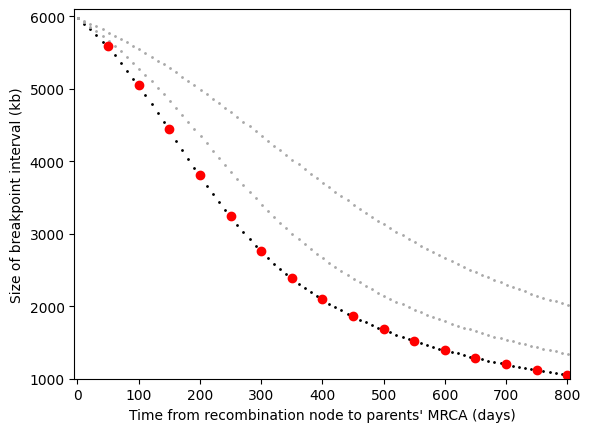

In [12]:
from scipy.optimize import curve_fit


# Successfully replicated results.
plt.ylim(1000, 6100)
plt.xlim(-5, 805)
plt.ylabel("Size of breakpoint interval (kb)")
plt.xlabel("Time from recombination node to parents' MRCA (days)")
plt.scatter(y=y_1, x=x, c="black", s=1)
plt.scatter(y=y_1_5, x=x, c="darkgray", s=1)
plt.scatter(y=y_2, x=x, c="darkgray", s=1)
plt.scatter(y=data[1, :], x=data[0, :], c="red");

# Fit curve.
#popt, pcov = curve_fit(fn, time_re_mrca, int_size)
#plt.scatter(y=fn(x, *popt), x=x, c="green");

In [13]:
def get_gene_coordinates():
    return {
        "ORF1ab": (266, 21555),
        "S": (21563, 25384),
        "ORF3a": (25393, 26220),
        "E": (26245, 26472),
        "M": (26523, 27191),
        "ORF6": (27202, 27387),
        "ORF7a": (27394, 27759),
        "ORF7b": (27756, 27887),
        "ORF8": (27894, 28259),
        "N": (28274, 29533),
        "ORF10": (29558, 29674),
    }


In [16]:
def plot_breakpoints(df, fig, ax1, ax2, L, xlim=None):
    dfs = df.sort_values("interval_left")
    dfs["length"] = df.interval_right - df.interval_left

    intervals = [(row.interval_left, row.interval_right) for (_, row) in dfs.iterrows()]

    norm = matplotlib.colors.Normalize(vmin=dfs.length.min(), vmax=dfs.length.max())
    cmap = matplotlib.colormaps["viridis"]

    lines = []
    colours = []
    for j, (left, right) in enumerate(intervals):
        assert left <= right
        lines.append(((left, j), (right, j)))
        colours.append(cmap(norm(right - left)))
    lc = mc.LineCollection(lines, colors=colours)

    ax1.add_collection(lc)
    ax1.autoscale()

    #im1 = ax1.imshow([[1, 2], [2, 3]])
    axins1 = inset_axes(
        ax1,
        width="2.5%", 
        height="50%",  
        loc="upper left",
    )
    #axins1.xaxis.set_ticks_position("bottom")
    fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), 
        cax=axins1, 
        orientation="vertical",
        format=mticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}kb")
    )

    covers = np.zeros(L)
    for left, right in intervals:
        covers[left:right] += 1

    ax2.set_ylabel("Number of intersecting intervals")
    ax2.plot(covers)

    if xlim is not None:
        for ax in [ax1, ax2]:
            ax.set_xlim(xlim)

    genes = get_gene_coordinates()
    j = 0
    mids = []
    for gene, (left, right) in genes.items():
        mids.append(left + (right - left) / 2)
        j += 1
        for ax in [ax1, ax2]:
            if j % 2 == 1:
                ax.axvspan(left, right, color="black", alpha=0.1, zorder=0)
            else:
                ax.axvspan(left, right, color="green", alpha=0.1, zorder=0)

    for ax in reversed([ax1, ax2]):
        axs = ax.secondary_xaxis("top")
        axs.tick_params(axis="x")
        axs.set_xticks(mids, minor=False)
        axs.set_xticklabels(["" for _ in genes.keys()], rotation="vertical")
    axs.set_xticklabels(list(genes.keys()), rotation="vertical")

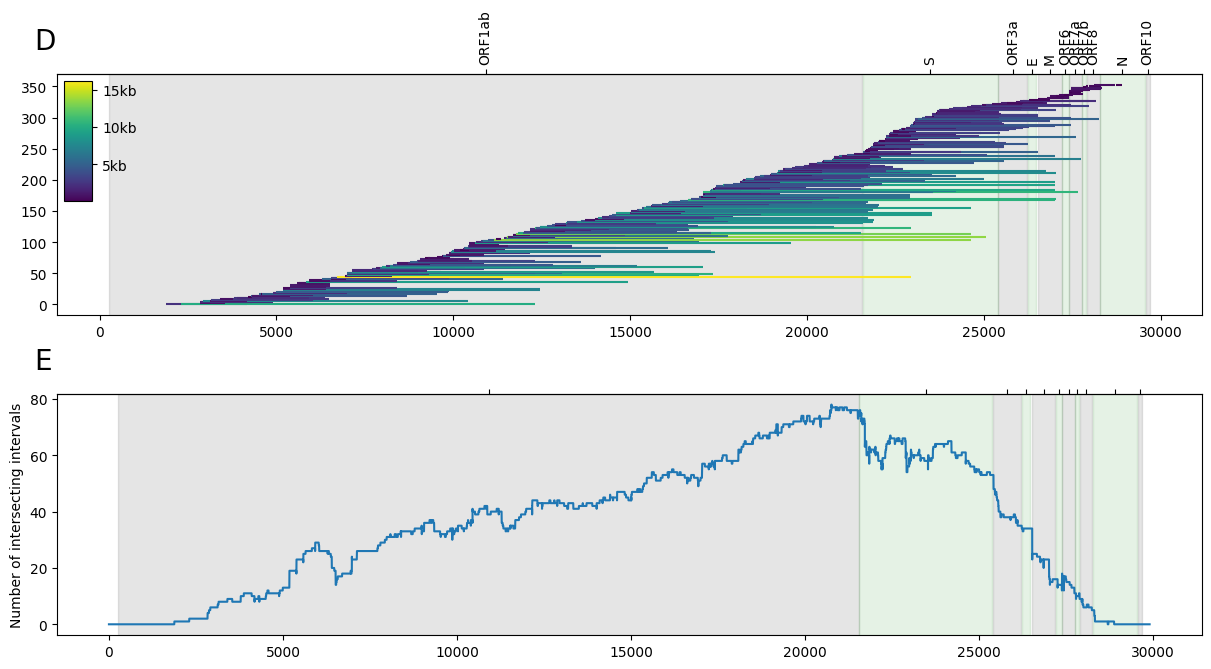

In [19]:
fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, wspace=0.05)
ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, :])
ax3.text(x=-0.02, y=1.1, s="D", size=20, transform=ax3.transAxes)
ax4.text(x=-0.02, y=1.1, s="E", size=20, transform=ax4.transAxes)
plot_breakpoints(df_hq, fig, ax3, ax4, L=29904)

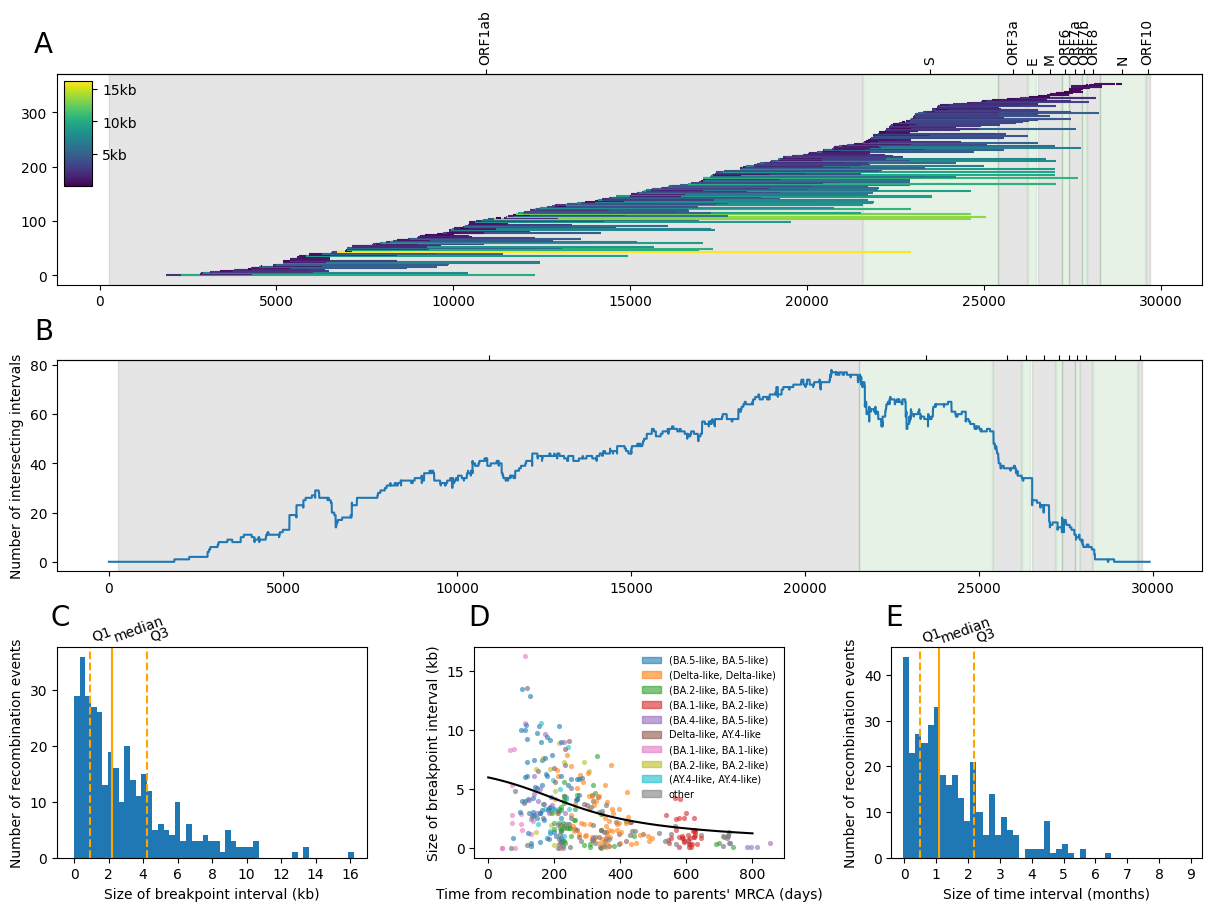

In [20]:
L = 29904

fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(nrows=3, ncols=3, wspace=0.05)
ax0 = fig.add_subplot(gs[2, 0])
ax1 = fig.add_subplot(gs[2, 1])
ax2 = fig.add_subplot(gs[2, 2])

# Distribution of size of breakpoint interval.

ax0.set_ylabel("Number of recombination events")
ax0.set_xlabel("Size of breakpoint interval (kb)")
ax0.set_xlim(-1, 17)
ax0.set_xticks(np.arange(0, 18, 2), labels=np.arange(0, 18, 2))
ax0.hist(int_size, bins=50)
quartiles = [1/4, 1/2, 3/4]
texts = ["Q1", "median", "Q3"]
for q, t in zip(quartiles, texts):
    ls = "solid" if q == 1/2 else "--"
    v = np.quantile(int_size, q)
    ax0.axvline(v, linestyle=ls, color="orange")
    ax0.text(x=v, y=ax0.get_ylim()[1] + 1, s=t, ha="left", rotation=20)

# Trade-off between breakpoint interval size and RE-parent MRCA time.
ax1.set_ylabel("Size of breakpoint interval (kb)")
ax1.set_xlabel("Time from recombination node to parents' MRCA (days)")
other_pairs = {"color": "gray", "abbrev": "other"}
for i, row in enumerate(df_hq.itertuples()):
    scorpio_pair = frozenset([row.parent_left_scorpio, row.parent_right_scorpio])
    color = label_map.get(scorpio_pair, other_pairs)["color"]
    alpha = 0.6 if color != other_pairs["color"] else 0.7
    ax1.scatter(
        y=int_size[i],
        x=time_re_mrca[i],
        s=14,
        linewidths=0,
        color=color,
        alpha=alpha,
    )

#assert ts.sequence_length - 1 == 29903
x = np.arange(1, 802, 10)
# https://www.nature.com/articles/s41579-023-00878-2
# No significant difference between non-VoCs and inside VoCs.
# ~2 × 10–6 per site per day
mu = (2 * 1e-6) * (L - 1)
y = fn(x, mu=mu)
ax1.plot(x, y/1000, color="black")

#empty_patch = mpatches.Patch(color='none', label='')
lab_texts = [label_map[k]["abbrev"] for k in label_map.keys()] + ["other"]
lab_cols = [label_map[k]["color"] for k in label_map.keys()] + [other_pairs["color"]]
ax1.legend(
    handles=[
        mpatches.Patch(label=t, color=c, alpha=0.6)
        for t, c in zip(lab_texts, lab_cols)
    ],
    fontsize=7,
    frameon=False,
)

# Distribution of size of time interval.

ax2.set_ylabel("Number of recombination events")
ax2.set_xlabel("Size of time interval (months)")
label_days = np.arange(1, 265, 27)
ax2.set_xticks(label_days, labels=np.arange(len(label_days)))
ax2.set_xlim(-10, 253)
ax2.hist(time_diffs, bins=50)
quartiles = [1/4, 1/2, 3/4]
texts = ["Q1", "median", "Q3"]
for q, t in zip(quartiles, texts):
    ls = "solid" if q == 1/2 else "--"
    v = np.quantile(time_diffs, q)
    ax2.axvline(v, linestyle=ls, color="orange")
    ax2.text(x=v, y=ax2.get_ylim()[1] + 1, s=t, ha="left", rotation=20);


ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, :])

ax3.text(x=-0.02, y=1.1, s="A", size=20, transform=ax3.transAxes)
ax4.text(x=-0.02, y=1.1, s="B", size=20, transform=ax4.transAxes)
ax0.text(x=-0.02, y=1.1, s="C", size=20, transform=ax0.transAxes)
ax1.text(x=-0.02, y=1.1, s="D", size=20, transform=ax1.transAxes)
ax2.text(x=-0.02, y=1.1, s="E", size=20, transform=ax2.transAxes)

plot_breakpoints(df_hq, fig, ax3, ax4, L)
plt.savefig("../figures/recombinant_intervals.pdf")